In [1]:
# Training a small convnet from scratch to classify a single binary label 'target_label' (e.g. agriculture)
# See: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
#%matplotlib inline

pal = sns.color_palette()

import os
import sys
module_path = os.path.abspath(os.path.join('.'))
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)

from utils.recorder import test_import
test_import()
from utils.file import makedirs

import cv2
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from datetime import datetime
import time

timestr = time.strftime("%Y%m%d-%H%M%S")
startTime = datetime.now()

C:\Users\Me\kaggle\amazon
local module import successful

Using Theano backend.
Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
c:\users\me\appdata\local\temp\try_flags_mffy7t.c:4:19: fatal error: cudnn.h: No such file or directory
compilation terminated.

Mapped name None to device cuda: GeForce GTX 1060 6GB (0000:01:00.0)


In [2]:
data_dir = 'D:/Downloads/amazon/'
target_label = 'road'
# ['slash_burn', 'clear', 'blooming', 'primary', 'cloudy', 'conventional_mine', 'water', 'haze', 'cultivation', 'partly_cloudy', 'artisinal_mine', 'habitation', 'bare_ground', 'blow_down', 'agriculture', 'road', 'selective_logging']
num_samples_per_epoch = 10000 #90000
# when > 10000 , notebook freezes, use command line
num_epoch = 8
train_dir = data_dir + 'prep/' + target_label + '/train-jpg'
validation_dir = data_dir + 'prep/' + target_label + '/validation-jpg'
batch_size = 64  # limited by GPU memory size and model size
num_validations_per_epoch = 600
# all images will be resized to 128x128, which reduces number of pixels by 4x.
rescaled_dim = 128
model_file = data_dir + 'models/' + target_label + '-' + timestr + '.h5'

In [3]:
model = Sequential()
model.add(Convolution2D(32, 3, 3, input_shape=(3, rescaled_dim, rescaled_dim)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',  # was binary_crossentropy
              optimizer='adam',
              metrics=['accuracy', 'recall', 'precision'])

In [4]:
# this is the augmentation configuration we will use for training
# TODO add rotation for small data set
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.0,
        zoom_range=0.0,
        horizontal_flip=True,
        vertical_flip=True)

# this is the configuration we will use for testing:
# only rescaling
validation_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolders of train_dir, and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(rescaled_dim, rescaled_dim),  
        batch_size=batch_size,
        class_mode='binary')

# this is a similar generator, for validation data
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(rescaled_dim, rescaled_dim),
        batch_size=batch_size,
        class_mode='binary')

Found 32383 images belonging to 2 classes.
Found 8096 images belonging to 2 classes.


In [5]:

history = model.fit_generator(
        train_generator,
        samples_per_epoch=num_samples_per_epoch, #  not using all training samples at every epoch.
        nb_epoch=num_epoch,
        validation_data=validation_generator,
        nb_val_samples=num_validations_per_epoch)
model.save(model_file)  # always save your model and weights after training or during training
print('done')

Epoch 1/8
 9984/10000 [============================>.] - ETA: 0s - loss: 0.4614 - acc: 0.8011 - recall: 0.1149 - precision: 0.3763  

C:\Users\Me\Anaconda2\lib\site-packages\keras\keras\engine\training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


10048/10000 [==============================] - 153s - loss: 0.4615 - acc: 0.8008 - recall: 0.1142 - precision: 0.3739 - val_loss: 0.4111 - val_acc: 0.8016 - val_recall: 0.1774 - val_precision: 0.6283
Epoch 2/8
10048/10000 [==============================] - 177s - loss: 0.4032 - acc: 0.8103 - recall: 0.2221 - precision: 0.5560 - val_loss: 0.4103 - val_acc: 0.8063 - val_recall: 0.2332 - val_precision: 0.7042

In [6]:
from utils.recorder import record_model_medata

time_spent_trianing = datetime.now() - startTime

record_model_medata(model_file, history, time_spent_trianing)

['acc', 'loss', 'recall', 'precision', 'val_acc', 'val_recall', 'val_precision', 'val_loss']


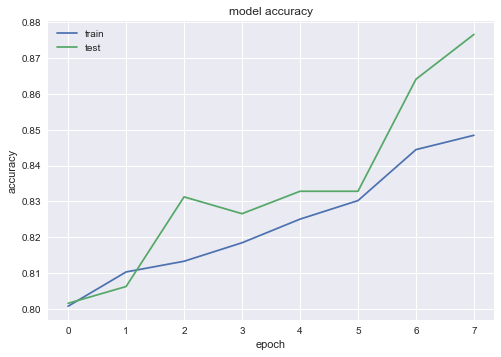

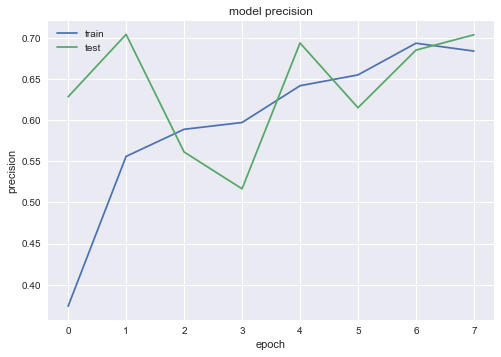

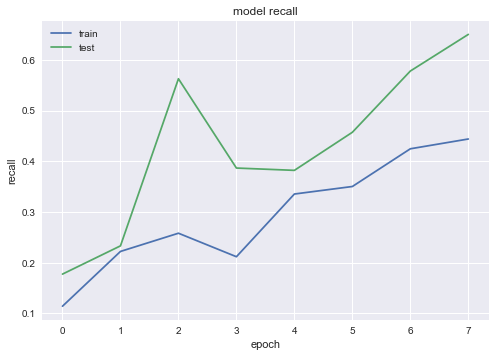

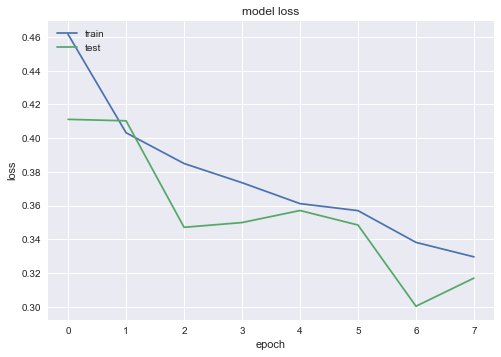

In [14]:
figures_dir = 'figures/' + target_label
makedirs(figures_dir)
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(figures_dir + '/accuracy_' + timestr + '.png')
plt.show()
# summarize history for precision
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(figures_dir + '/precision_' + timestr + '.png')
plt.show()
# summarize history for recall
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(figures_dir + '/recall_' + timestr + '.png')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(figures_dir + '/loss_' + timestr + '.png')
plt.show()

In [8]:
#from keras.models import load_model
#model = load_model(model_file)
#model = load_model(data_dir + 'models/agriculture-20170505-234342.h5')

In [9]:
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 32, 126, 126)  896         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 32, 126, 126)  0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 32, 63, 63)    0           activation_1[0][0]               
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 32, 61, 61)    9248        maxpooling2d_1[0][0]             
___________________________________________________________________________________________

In [10]:
testset_datagen = ImageDataGenerator(rescale=1./255)

testset_dir = data_dir + 'test'

testset_generator = testset_datagen.flow_from_directory(
        testset_dir,
        target_size=(rescaled_dim, rescaled_dim),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

Found 40669 images belonging to 1 classes.


In [11]:
testset_predict = model.predict_generator(testset_generator, 40669)


In [12]:
classifier_threshold = 0.5 # TODO https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/discussion/32475
y_testset_predictions = (np.array(testset_predict) > classifier_threshold).astype(int)

In [13]:
print ('total time spent to complete execution:' , datetime.now() - startTime)

('total time spent to complete execution:', datetime.timedelta(0, 1775, 904000))
